# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from dotenv import load_dotenv
from googleapiclient.discovery import build

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

## Get environment variables for api key and channel id(s)
* *Change appropriate code to use channel_ids if using multiple channel ids within the environment variable*

In [2]:
load_dotenv()

api_key = os.getenv('api_key')
channel_id = os.getenv('channel_id')
#channel_ids = os.getenv('channel_ids')

youtube = build('youtube', 'v3', developerKey = api_key)

## Function to retrieve channel statistics

In [3]:
def get_channel_stats(youtube, 
                      channel_id
                      #channel_ids
                     ):
    all_data = []
    request = youtube.channels().list(
                part = 'snippet, contentDetails, statistics',
                #id = ','.join(channel_ids))
                id = channel_id)
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(channel_name = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    total_videos = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    return all_data

In [4]:
channel_stats = get_channel_stats(youtube, channel_id)

## Load channel stats into pandas dataframe
### Data cleaning and processing

In [5]:
channel_data = pd.DataFrame(channel_stats)

In [6]:
channel_data

,channel_name,subscribers,views,total_videos,playlist_id
0,Mathilification,171000,85628449,1299,UUnaP100kTBB_WGM9IiF73yw


In [7]:
channel_data.dtypes

channel_name    object
subscribers     object
views           object
total_videos    object
playlist_id     object
dtype: object

In [8]:
channel_data['subscribers'] = pd.to_numeric(channel_data['subscribers'])
channel_data['views'] = pd.to_numeric(channel_data['views'])
channel_data['total_videos'] = pd.to_numeric(channel_data['total_videos'])
channel_data.dtypes

channel_name    object
subscribers      int64
views            int64
total_videos     int64
playlist_id     object
dtype: object

In [9]:
channel_data

,channel_name,subscribers,views,total_videos,playlist_id
0,Mathilification,171000,85628449,1299,UUnaP100kTBB_WGM9IiF73yw


In [10]:
playlist_id = channel_data.loc[channel_data['channel_name'] == 'Mathilification', 'playlist_id'].iloc[0]

## Functions to retrieve video IDs and video statistics.

In [11]:
def get_video_ids(youtube, playlist_id):
    request = youtube.playlistItems().list(
                part = 'contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part = 'contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
            
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
                
            next_page_token = response.get('nextPageToken')
            
    return video_ids

In [12]:
video_ids = get_video_ids(youtube, playlist_id)

In [13]:
#video_ids

In [14]:
def get_video_details(youtube, video_ids):
    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part = 'snippet, statistics',
                    id = ','.join(video_ids[i:i+50]))
        response = request.execute()
        
        for video in response['items']:
            #if video['id']['kind'] == "youtube#video":
                video_stats = dict(title = video['snippet']['title'],
                                   upload_date = video['snippet']['publishedAt'],
                                   view_count = video['statistics']['viewCount'],
                                   like_count = video['statistics']['likeCount'],
                                   #dislike_count = video['statistics']['dislikeCount'],
                                   comment_count = video['statistics']['commentCount'],
                                   #favorite_count = video['statistics']['favoriteCount']
                                  )
                all_video_stats.append(video_stats)
    return all_video_stats         

In [15]:
video_details = get_video_details(youtube, video_ids)

## Load video statistics into pandas dataframe
### Data cleaning and processing

In [16]:
video_data = pd.DataFrame(video_details)

In [17]:
video_data

,title,upload_date,view_count,like_count,comment_count
0,Back From Korea & Affliction League Is Looking...,2023-12-04T19:11:10Z,27436,760,89
1,C*mStorm Starter Guide From Shifting Stones Ev...,2023-11-20T19:05:44Z,25204,518,48
2,Deadeye Ice Spear Starter Hitting 95 & Undergo...,2023-11-18T18:45:23Z,18288,318,31
3,Ice Spear Deadeye Feels As Amazing As Ever For...,2023-11-14T19:09:56Z,30800,508,47
4,Forbidden Rite Poison Pathfinder Delivers Some...,2023-11-10T18:51:56Z,11698,237,10
...,...,...,...,...,...
1293,77 Shrine Piety,2013-12-16T03:18:01Z,6678,14,3
1294,"Exalting win, for once",2013-12-12T23:51:02Z,4504,20,7
1295,2x Dominus,2013-12-12T05:08:53Z,5945,17,3
1296,"Vaal 74 Maze, temp chains, other stuff",2013-12-12T03:26:42Z,6123,14,2


In [18]:
video_data.dtypes

title            object
upload_date      object
view_count       object
like_count       object
comment_count    object
dtype: object

In [19]:
video_data['upload_date'] = pd.to_datetime(video_data['upload_date']).dt.date
video_data['view_count'] = pd.to_numeric(video_data['view_count'])
video_data['like_count'] = pd.to_numeric(video_data['like_count'])
video_data['comment_count'] = pd.to_numeric(video_data['comment_count'])
video_data

,title,upload_date,view_count,like_count,comment_count
0,Back From Korea & Affliction League Is Looking...,2023-12-04,27436,760,89
1,C*mStorm Starter Guide From Shifting Stones Ev...,2023-11-20,25204,518,48
2,Deadeye Ice Spear Starter Hitting 95 & Undergo...,2023-11-18,18288,318,31
3,Ice Spear Deadeye Feels As Amazing As Ever For...,2023-11-14,30800,508,47
4,Forbidden Rite Poison Pathfinder Delivers Some...,2023-11-10,11698,237,10
...,...,...,...,...,...
1293,77 Shrine Piety,2013-12-16,6678,14,3
1294,"Exalting win, for once",2013-12-12,4504,20,7
1295,2x Dominus,2013-12-12,5945,17,3
1296,"Vaal 74 Maze, temp chains, other stuff",2013-12-12,6123,14,2


In [20]:
top10_by_views = video_data.sort_values(by = 'view_count', ascending = False).head(10)
top10_by_views

,title,upload_date,view_count,like_count,comment_count
963,A Simple Blade Flurry Assassin - Full Guide (F...,2016-11-22,662694,2818,598
950,Raider Cyclone is Almost TOO Fast... Almost,2016-12-16,527030,2270,461
732,Starter Builds for Incursion League & 3.3.0 Sk...,2018-06-01,435657,2009,241
980,How I level A Character (mostly new player stuff),2016-10-16,387821,4015,302
850,Harbinger League & Fall of Oriath Starter Builds,2017-08-03,371911,2488,396
915,Starter Builds for Legacy League,2017-03-03,353428,2109,483
965,Blade Flurry is Insane - Mechanics Display and...,2016-11-18,350061,1101,243
957,Effective Starter Builds for Breach League,2016-12-02,337130,1616,370
780,Probably My Highest Endgame DPS Char - Inpulsa...,2018-01-24,318299,1805,209
510,Metamorph 3.9 League Starter Builds,2019-12-13,312884,2517,243


## Graphical Analysis

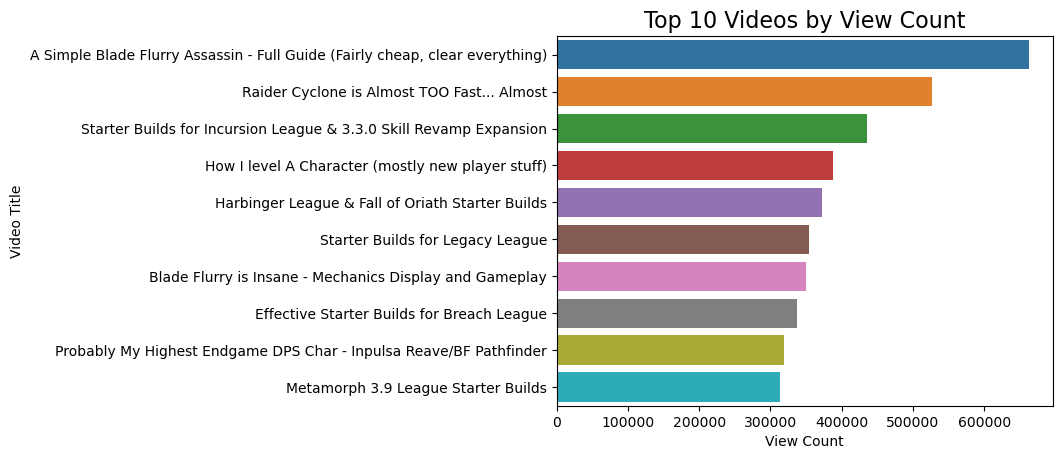

In [21]:
bar1 = sns.barplot(data = top10_by_views, x = 'view_count', y = 'title')
bar1.set_title("Top 10 Videos by View Count", fontsize = 16)
bar1.set_xlabel("View Count")
bar1.set_ylabel("Video Title")
plt.show()

In [22]:
video_data['Month'] = pd.to_datetime(video_data['upload_date']).dt.strftime('%b')
video_data['Day'] = pd.to_datetime(video_data['upload_date']).dt.strftime('%d')
video_data['Year'] = pd.to_datetime(video_data['upload_date']).dt.strftime('%Y')
video_data

,title,upload_date,view_count,like_count,comment_count,Month,Day,Year
0,Back From Korea & Affliction League Is Looking...,2023-12-04,27436,760,89,Dec,04,2023
1,C*mStorm Starter Guide From Shifting Stones Ev...,2023-11-20,25204,518,48,Nov,20,2023
2,Deadeye Ice Spear Starter Hitting 95 & Undergo...,2023-11-18,18288,318,31,Nov,18,2023
3,Ice Spear Deadeye Feels As Amazing As Ever For...,2023-11-14,30800,508,47,Nov,14,2023
4,Forbidden Rite Poison Pathfinder Delivers Some...,2023-11-10,11698,237,10,Nov,10,2023
...,...,...,...,...,...,...,...,...
1293,77 Shrine Piety,2013-12-16,6678,14,3,Dec,16,2013
1294,"Exalting win, for once",2013-12-12,4504,20,7,Dec,12,2013
1295,2x Dominus,2013-12-12,5945,17,3,Dec,12,2013
1296,"Vaal 74 Maze, temp chains, other stuff",2013-12-12,6123,14,2,Dec,12,2013


In [23]:
videos_per_month = video_data.groupby('Month', as_index = False).size()
videos_per_month

,Month,size
0,Apr,100
1,Aug,121
2,Dec,116
3,Feb,92
4,Jan,105
5,Jul,109
6,Jun,100
7,Mar,107
8,May,100
9,Nov,113


In [24]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [25]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories = sort_order, ordered = True)
videos_per_month = videos_per_month.sort_index()

In [26]:
videos_per_month

,Month,size
Month,,
Jan,Jan,105
Feb,Feb,92
Mar,Mar,107
Apr,Apr,100
May,May,100
Jun,Jun,100
Jul,Jul,109
Aug,Aug,121
Sep,Sep,119


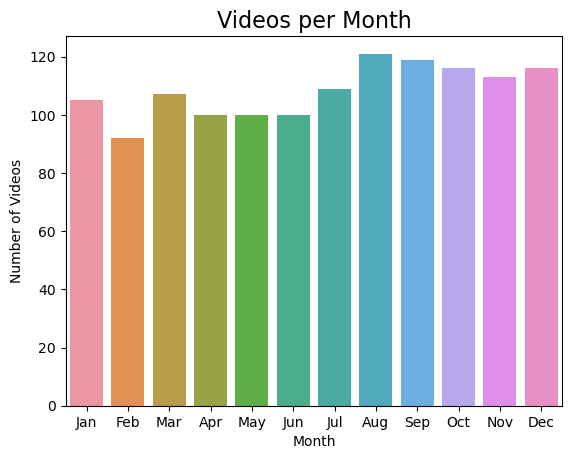

In [27]:
bar2 = sns.barplot(data = videos_per_month, x = 'Month', y = 'size')
bar2.set_ylabel('Number of Videos')
bar2.set_title('Videos per Month', fontsize = 16)
plt.show()

In [28]:
video_data.to_csv('Mathil Youtube.csv')

In [29]:
top10_by_likes = video_data.sort_values(by = 'like_count', ascending = False).head(10)
top10_by_likes

,title,upload_date,view_count,like_count,comment_count,Month,Day,Year
445,"""Mathil, aren't you burnt out of PoE?""",2020-05-24,167001,5659,491,May,24,2020
411,Harvest Crafting Is Not Going Core And That's ...,2020-08-14,64693,4261,1523,Aug,14,2020
980,How I level A Character (mostly new player stuff),2016-10-16,387821,4015,302,Oct,16,2016
256,A Day In The Life Of A Mathil1 & Apartment Tour,2021-10-23,82324,3916,337,Oct,23,2021
150,Opinions On Recent Lake of Kalandra Drama & Ga...,2022-08-23,117335,3770,683,Aug,23,2022
519,Gamer 6 Pack Abs - 5 Years of Streaming Later,2019-11-14,138984,3588,548,Nov,14,2019
614,"Synthesis - Don't worry, I don't get it either",2019-03-15,147241,3073,711,Mar,15,2019
657,Starter Builds For Betrayal League,2018-12-06,279375,2939,344,Dec,06,2018
963,A Simple Blade Flurry Assassin - Full Guide (F...,2016-11-22,662694,2818,598,Nov,22,2016
644,Crafting God-like Items With Bestiary System &...,2019-01-03,245738,2667,226,Jan,03,2019


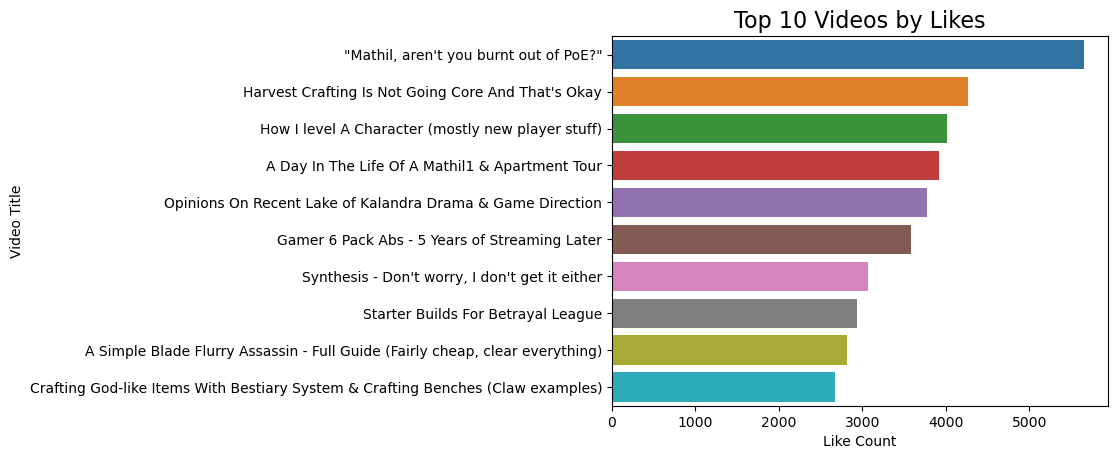

In [30]:
bar3 = sns.barplot(data = top10_by_likes, x = 'like_count', y = 'title')
bar3.set_title("Top 10 Videos by Likes", fontsize = 16)
bar3.set_xlabel("Like Count")
bar3.set_ylabel("Video Title")
plt.show()

In [31]:
videos_per_year = video_data.groupby('Year', as_index = False).size()
videos_per_year

,Year,size
0,2013,9
1,2014,89
2,2015,91
3,2016,166
4,2017,153
5,2018,144
6,2019,144
7,2020,140
8,2021,127
9,2022,132


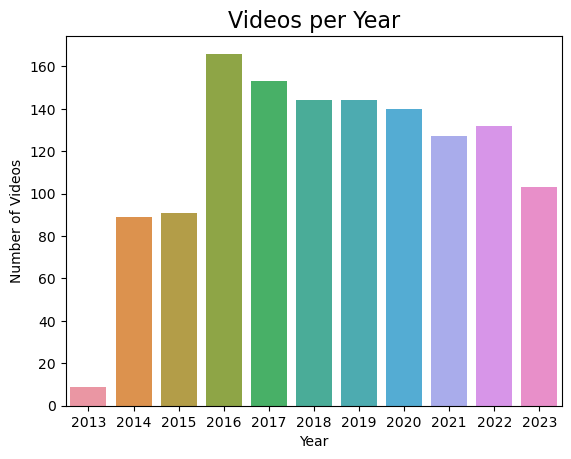

In [32]:
bar4 = sns.barplot(data = videos_per_year, x = 'Year', y = 'size')
bar4.set_ylabel('Number of Videos')
bar4.set_title('Videos per Year', fontsize = 16)
plt.show()

In [33]:
df = video_data.groupby(['Year', 'Month'], as_index = False).size()
df

,Year,Month,size
0,2013,Dec,9
1,2014,Aug,14
2,2014,Dec,9
3,2014,Jul,11
4,2014,Jun,1
5,2014,Mar,7
6,2014,May,1
7,2014,Nov,14
8,2014,Oct,16
9,2014,Sep,16


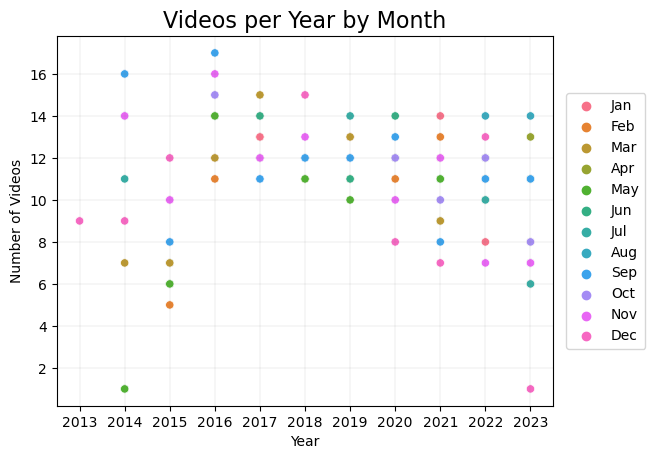

In [34]:
scat1 = sns.scatterplot(data = df, x = 'Year', y = 'size', hue_order = sort_order, hue = 'Month')
scat1.legend(loc = 'center right', bbox_to_anchor = (1.2, 0.5))
scat1.set_title("Videos per Year by Month", fontsize = 16)
scat1.set_ylabel("Number of Videos")
scat1.grid(which = 'major', color = 'grey', linewidth = 0.1)
plt.show()